# Principal Nested Spheres (PNS) for Dimension Reduction on Spheres

This notebook demonstrates the use of Principal Nested Spheres (PNS), a method for recursive dimension reduction on spherical data.

## Overview

Principal Nested Spheres is a generalization of Principal Component Analysis (PCA) to spherical manifolds. While PCA reduces dimensionality by projecting data onto nested linear subspaces, PNS projects data onto nested subspheres of decreasing dimension.

### Key Features:
- **Recursive dimension reduction**: Progressively reduces sphere dimension from $S^n$ to $S^1$
- **Preserves spherical structure**: Unlike tangent PCA, stays on the manifold
- **Multiple fitting modes**: Adaptive, great sphere, or small sphere fitting
- **Captures non-linear patterns**: Better suited for data with spherical distribution

### Reference:
Jung, S., Dryden, I. L., & Marron, J. S. (2012). Analysis of principal nested spheres. *Biometrika*, 99(3), 551-568.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import geomstats.backend as gs
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.learning.principal_nested_spheres import PrincipalNestedSpheres
from geomstats.learning.frechet_mean import FrechetMean

# Set random seed for reproducibility
gs.random.seed(42)
np.random.seed(42)

INFO: NumExpr defaulting to 8 threads.


## 1. Basic Example: Random Data on $S^2$

Let's start with a simple example using uniformly distributed data on the 2-sphere.

In [2]:
# Create sphere and generate random data
sphere = Hypersphere(dim=2)
n_samples = 50
X = sphere.random_uniform(n_samples=n_samples)

print(f"Data shape: {X.shape}")
print(f"First 3 points:\n{X[:3]}")

Data shape: (50, 3)
First 3 points:
[[ 0.60000205 -0.1670153   0.78237039]
 [ 0.97717133 -0.15023209 -0.15022156]
 [ 0.86889694  0.42224942 -0.25830898]]


In [3]:
# Fit PNS with default (adaptive) mode
pns = PrincipalNestedSpheres(space=sphere, n_init=10, verbose=True)
pns.fit(X)

# Transform to reduced representation on S^1
X_reduced = pns.transform(X)

print(f"\nReduced data shape: {X_reduced.shape}")
print(f"\nNumber of nested subspheres fitted: {len(pns.nested_spheres_)}")
print(f"Mean on S^1: {pns.mean_}")

INFO: Likelihood comparison: chi2=0.000, mle_rho=3.647, mle_sigma=0.294, mle_null_sigma=0.657
INFO: Fitted S^2 in R^3: normal=[-0.89156717 -0.21331575 -0.39950516], height=0.045493



Reduced data shape: (50, 2)

Number of nested subspheres fitted: 1
Mean on S^1: [-0.6271512  -0.77889754]


### Visualizing the Reduction

The data has been reduced from $S^2$ (embedded in $\mathbb{R}^3$) to $S^1$ (embedded in $\mathbb{R}^2$).

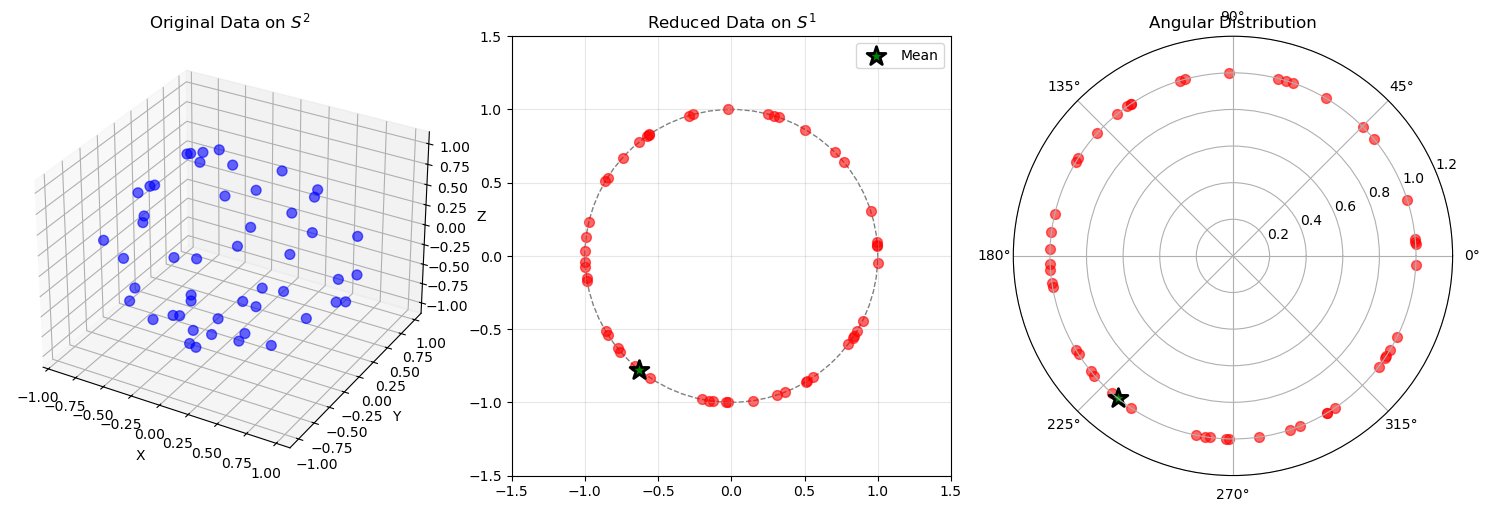

In [4]:
# Visualize original data on S^2
try:
    from geomstats.visualization.hypersphere import Sphere as SpherePlot
    
    fig = plt.figure(figsize=(15, 5))
    
    # Original data on S^2
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', alpha=0.6, s=50)
    ax1.set_title('Original Data on $S^2$', fontsize=12)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Reduced data on S^1
    ax2 = fig.add_subplot(132)
    angles = gs.arctan2(X_reduced[:, 1], X_reduced[:, 0])
    circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
    ax2.add_patch(circle)
    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c='red', alpha=0.6, s=50)
    ax2.scatter(pns.mean_[0], pns.mean_[1], c='green', s=200, marker='*', 
               label='Mean', edgecolors='black', linewidth=2)
    ax2.set_xlim(-1.5, 1.5)
    ax2.set_ylim(-1.5, 1.5)
    ax2.set_aspect('equal')
    ax2.set_title('Reduced Data on $S^1$', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Angular distribution
    ax3 = fig.add_subplot(133, projection='polar')
    ax3.scatter(angles, np.ones_like(angles), c='red', alpha=0.6, s=50)
    mean_angle = gs.arctan2(pns.mean_[1], pns.mean_[0])
    ax3.scatter(mean_angle, 1, c='green', s=200, marker='*', 
               edgecolors='black', linewidth=2)
    ax3.set_title('Angular Distribution', fontsize=12)
    ax3.set_ylim(0, 1.2)
    
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Visualization requires matplotlib. Skipping plots.")

## 2. Structured Data Example: Von Mises-Fisher Distribution

Let's create data with more structure using a Von Mises-Fisher distribution, which concentrates points around a mean direction.

In [5]:
# Generate concentrated data using Von Mises-Fisher distribution
mean_direction = gs.array([1., 0., 0.])  # North pole
kappa = 10  # Concentration parameter (higher = more concentrated)

X_vmf = sphere.random_von_mises_fisher(kappa=kappa, n_samples=100)

# Fit PNS
pns_vmf = PrincipalNestedSpheres(space=sphere, n_init=10)
pns_vmf.fit(X_vmf)
X_vmf_reduced = pns_vmf.transform(X_vmf)

print(f"Fitted {len(pns_vmf.nested_spheres_)} nested subsphere(s)")
print(f"Mean on S^1: {pns_vmf.mean_}")

Fitted 1 nested subsphere(s)
Mean on S^1: [-0.78906965 -0.61430374]


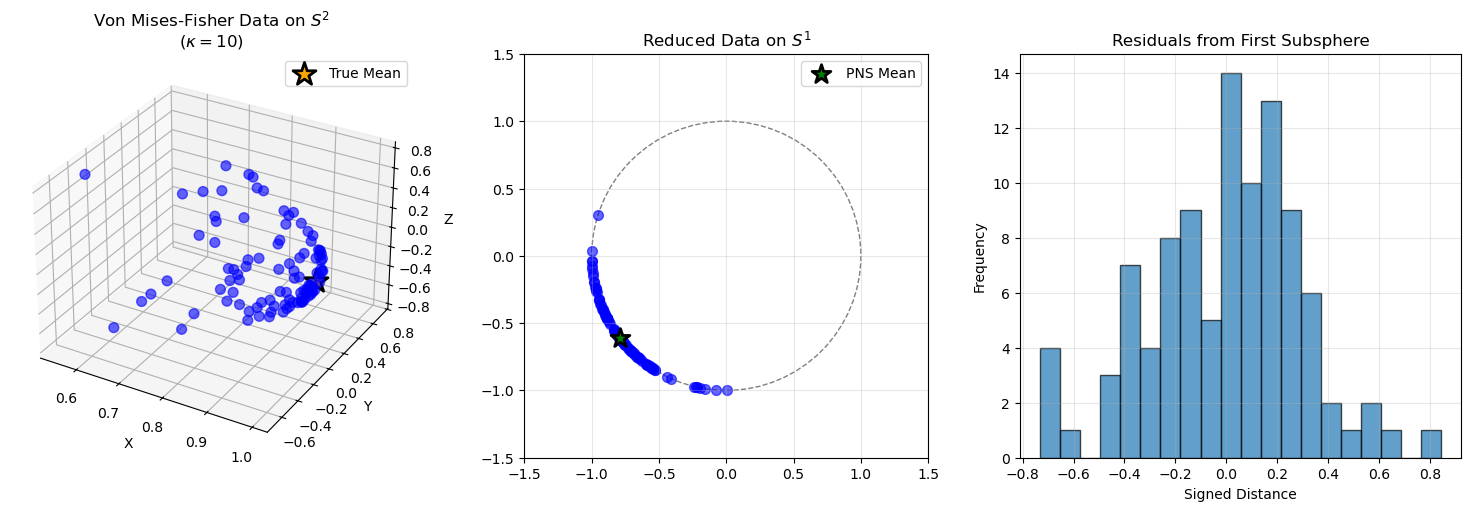

In [6]:
# Visualize structured data
fig = plt.figure(figsize=(15, 5))

# Original data on S^2
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_vmf[:, 0], X_vmf[:, 1], X_vmf[:, 2], c='blue', alpha=0.6, s=50)
ax1.scatter([1], [0], [0], c='orange', s=300, marker='*', 
           edgecolors='black', linewidth=2, label='True Mean')
ax1.set_title('Von Mises-Fisher Data on $S^2$\n($\\kappa=10$)', fontsize=12)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Reduced data on S^1
ax2 = fig.add_subplot(132)
angles_vmf = gs.arctan2(X_vmf_reduced[:, 1], X_vmf_reduced[:, 0])
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
ax2.add_patch(circle)
ax2.scatter(X_vmf_reduced[:, 0], X_vmf_reduced[:, 1], c='blue', alpha=0.6, s=50)
ax2.scatter(pns_vmf.mean_[0], pns_vmf.mean_[1], c='green', s=200, marker='*', 
           label='PNS Mean', edgecolors='black', linewidth=2)
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.set_title('Reduced Data on $S^1$', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Residuals histogram
ax3 = fig.add_subplot(133)
residuals_1 = gs.to_numpy(pns_vmf.residuals_[0])
ax3.hist(residuals_1, bins=20, alpha=0.7, edgecolor='black')
ax3.set_title('Residuals from First Subsphere', fontsize=12)
ax3.set_xlabel('Signed Distance')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Comparison of Fitting Modes

PNS supports three fitting modes:
- **`adaptive`** (default): Automatically chooses between great and small spheres based on statistical tests
- **`great`**: Fits great spheres (subspheres passing through the center)
- **`small`**: Fits small spheres (subspheres not passing through the center)

Let's compare these modes on the same dataset.

In [7]:
# Generate test data
X_test = sphere.random_von_mises_fisher(kappa=5, n_samples=80)

# Fit with different modes
modes = ['adaptive', 'great', 'small']
results = {}

for mode in modes:
    print(f"\n{'='*50}")
    print(f"Fitting mode: {mode}")
    print(f"{'='*50}")
    
    pns_mode = PrincipalNestedSpheres(space=sphere, sphere_mode=mode, n_init=10, verbose=False)
    pns_mode.fit(X_test)
    X_mode_reduced = pns_mode.transform(X_test)
    
    results[mode] = {
        'pns': pns_mode,
        'reduced': X_mode_reduced,
        'residuals': pns_mode.residuals_
    }
    
    # Print subsphere information
    for i, (normal, height) in enumerate(pns_mode.nested_spheres_):
        sphere_type = 'great' if abs(height) < 1e-6 else 'small'
        print(f"  Subsphere {i+1}: {sphere_type} sphere (height={height:.6f})")
    
    print(f"  Mean residual: {gs.mean(gs.abs(pns_mode.residuals_[0])):.6f}")


Fitting mode: adaptive
  Subsphere 1: great sphere (height=0.000000)
  Mean residual: 0.332649

Fitting mode: great
  Subsphere 1: great sphere (height=0.000000)
  Mean residual: 0.332648

Fitting mode: small
  Subsphere 1: small sphere (height=0.781027)
  Mean residual: 0.241086


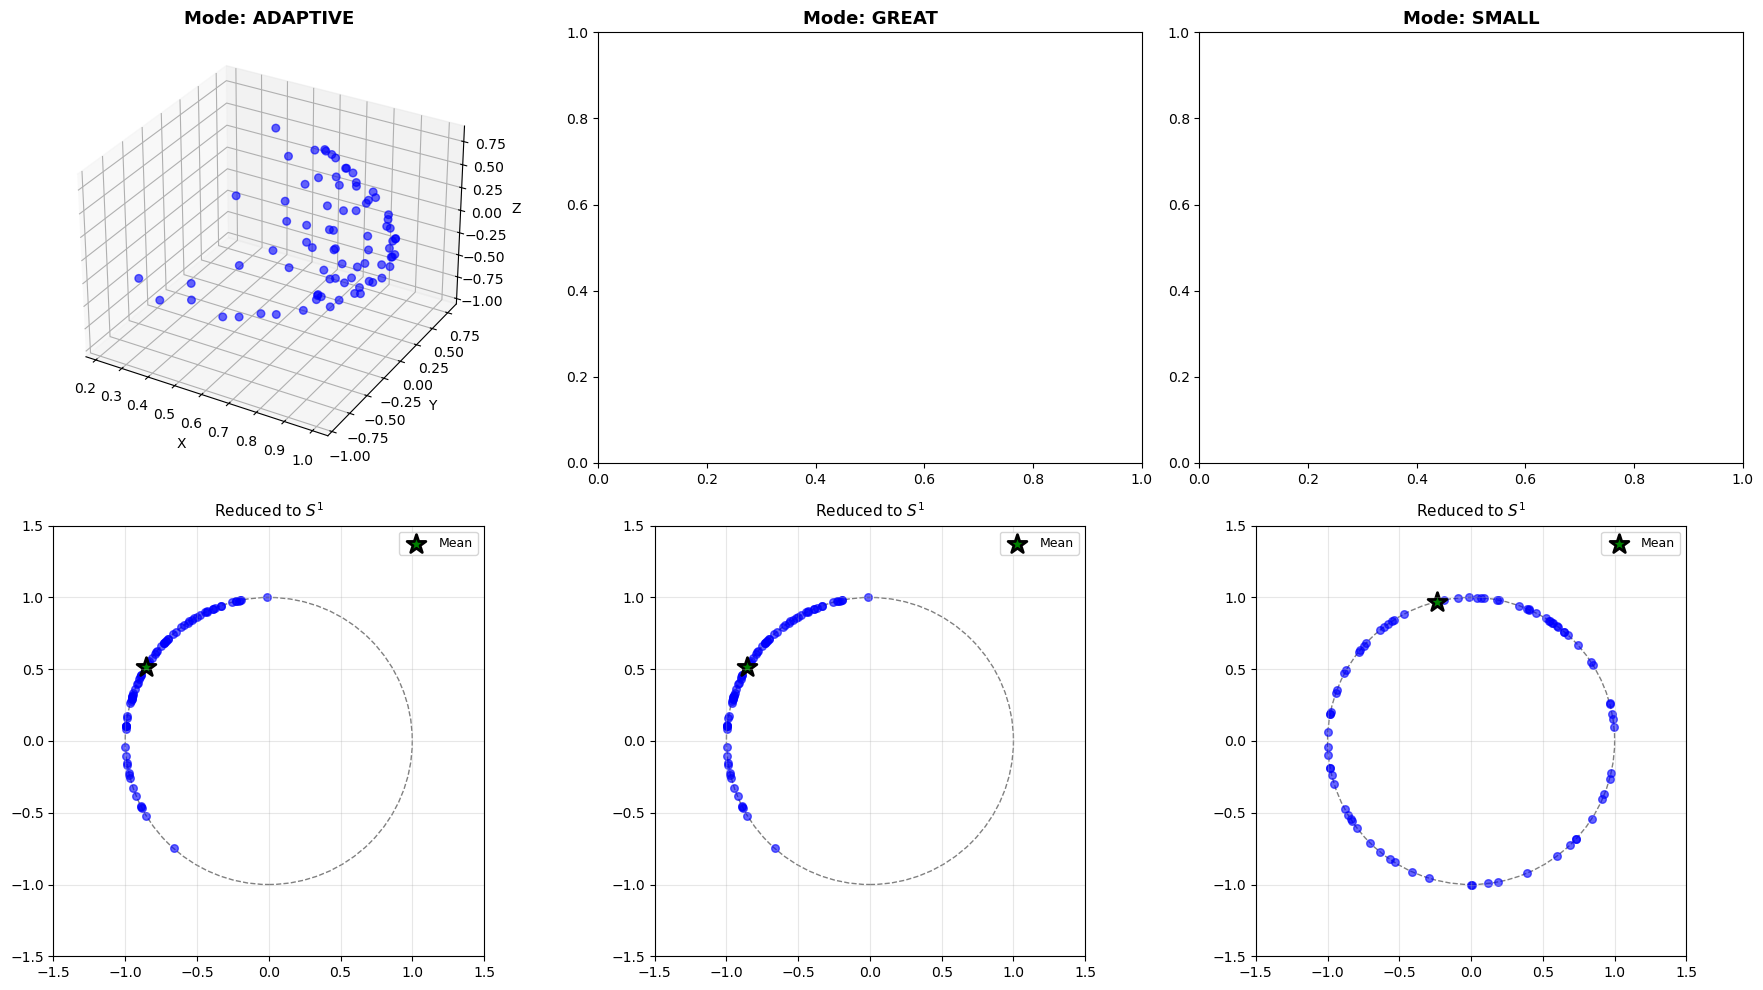


Residual Statistics:
Mode         Mean |Residual|      Std Residual   
--------------------------------------------------
adaptive     0.332649             0.418658       
great        0.332648             0.418658       
small        0.241086             0.284701       


In [8]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, mode in enumerate(modes):
    # Original data
    ax1 = axes[0, idx]
    if idx == 0:
        # 3D plot for first column
        from mpl_toolkits.mplot3d import Axes3D
        ax1.remove()
        ax1 = fig.add_subplot(2, 3, idx+1, projection='3d')
        ax1.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='blue', alpha=0.6, s=30)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
    ax1.set_title(f'Mode: {mode.upper()}', fontsize=13, fontweight='bold')
    
    # Reduced data on S^1
    ax2 = axes[1, idx]
    X_red = results[mode]['reduced']
    circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
    ax2.add_patch(circle)
    ax2.scatter(X_red[:, 0], X_red[:, 1], c='blue', alpha=0.6, s=30)
    mean = results[mode]['pns'].mean_
    ax2.scatter(mean[0], mean[1], c='green', s=200, marker='*', 
               label='Mean', edgecolors='black', linewidth=2)
    ax2.set_xlim(-1.5, 1.5)
    ax2.set_ylim(-1.5, 1.5)
    ax2.set_aspect('equal')
    ax2.set_title(f'Reduced to $S^1$', fontsize=11)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare residual statistics
print("\nResidual Statistics:")
print(f"{'Mode':<12} {'Mean |Residual|':<20} {'Std Residual':<15}")
print("-" * 50)
for mode in modes:
    res = gs.to_numpy(results[mode]['residuals'][0])
    print(f"{mode:<12} {np.mean(np.abs(res)):<20.6f} {np.std(res):<15.6f}")

## 4. Higher-Dimensional Example: $S^5 \rightarrow S^1$

Let's demonstrate PNS on higher-dimensional sphere data, progressively reducing from $S^5$ to $S^1$.

In [9]:
# Create higher-dimensional sphere
sphere_5 = Hypersphere(dim=5)
X_high = sphere_5.random_von_mises_fisher(kappa=3, n_samples=100)

print(f"Original data shape: {X_high.shape}")
print(f"Data lives on S^5 (embedded in R^6)")

# Fit PNS
pns_high = PrincipalNestedSpheres(space=sphere_5, n_init=15, verbose=False)
pns_high.fit(X_high)
X_high_reduced = pns_high.transform(X_high)

print(f"\nReduced data shape: {X_high_reduced.shape}")
print(f"Data reduced to S^1 (embedded in R^2)")
print(f"\nNumber of nested subspheres: {len(pns_high.nested_spheres_)}")

# Print information about each nested subsphere
print("\nNested Subsphere Details:")
for i, (normal, height) in enumerate(pns_high.nested_spheres_):
    sphere_type = 'great' if abs(height) < 1e-6 else 'small'
    residuals = gs.to_numpy(pns_high.residuals_[i])
    print(f"  S^{5-i} → S^{4-i}: {sphere_type} sphere, "
          f"height={height:.4f}, mean |residual|={np.mean(np.abs(residuals)):.4f}")

Original data shape: (100, 6)
Data lives on S^5 (embedded in R^6)

Reduced data shape: (100, 2)
Data reduced to S^1 (embedded in R^2)

Number of nested subspheres: 4

Nested Subsphere Details:
  S^5 → S^4: small sphere, height=0.1906, mean |residual|=0.2449
  S^4 → S^3: small sphere, height=0.0126, mean |residual|=0.3281
  S^3 → S^2: small sphere, height=0.2739, mean |residual|=0.3824
  S^2 → S^1: small sphere, height=0.1444, mean |residual|=0.4986


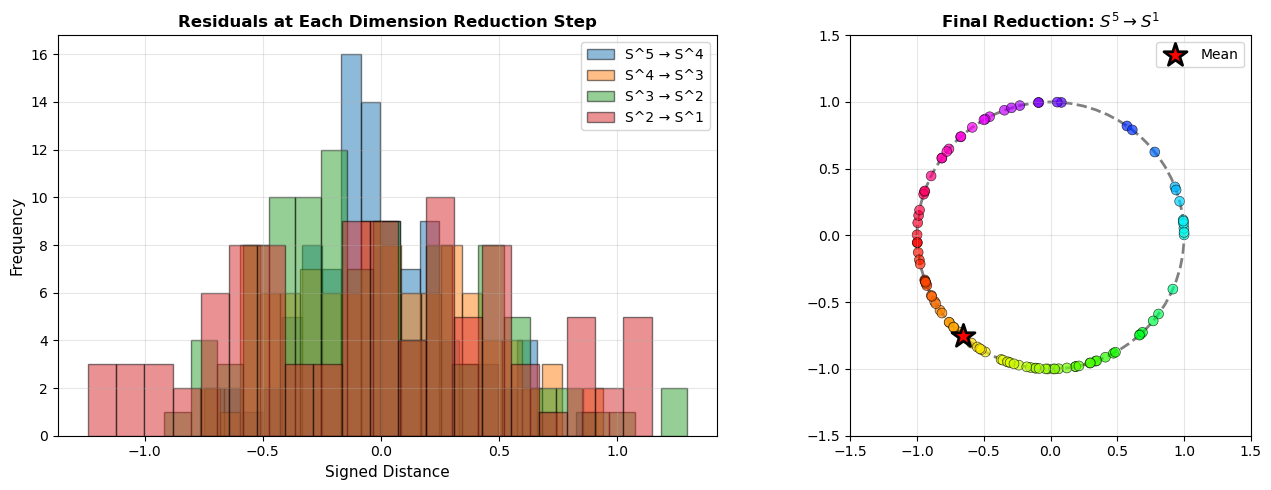

In [10]:
# Visualize the progressive dimension reduction
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Residuals at each level
ax1 = axes[0]
for i, residuals in enumerate(pns_high.residuals_):
    res = gs.to_numpy(residuals)
    ax1.hist(res, bins=20, alpha=0.5, label=f'S^{5-i} → S^{4-i}', edgecolor='black')
ax1.set_xlabel('Signed Distance', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Residuals at Each Dimension Reduction Step', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Final reduced data on S^1
ax2 = axes[1]
angles_high = gs.arctan2(X_high_reduced[:, 1], X_high_reduced[:, 0])
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', linewidth=2)
ax2.add_patch(circle)
ax2.scatter(X_high_reduced[:, 0], X_high_reduced[:, 1], 
           c=angles_high, cmap='hsv', alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
ax2.scatter(pns_high.mean_[0], pns_high.mean_[1], c='red', s=300, marker='*', 
           label='Mean', edgecolors='black', linewidth=2, zorder=10)
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.set_title('Final Reduction: $S^5 \\rightarrow S^1$', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Comparison with Tangent PCA

Let's compare PNS with Tangent PCA, which is the standard approach for dimension reduction on manifolds.

In [11]:
from geomstats.learning.pca import TangentPCA

# Generate test data
sphere_3 = Hypersphere(dim=3)
X_compare = sphere_3.random_von_mises_fisher(kappa=5, n_samples=100)

# Fit PNS
pns_compare = PrincipalNestedSpheres(space=sphere_3, n_init=10)
pns_compare.fit(X_compare)
X_pns = pns_compare.transform(X_compare)

# Fit Tangent PCA
tpca = TangentPCA(space=sphere_3, n_components=2)
tpca.fit(X_compare)
X_tpca = tpca.transform(X_compare)

print("Principal Nested Spheres:")
print(f"  Output shape: {X_pns.shape}")
print(f"  Output space: S^1 (manifold)")
print(f"  Nested subspheres: {len(pns_compare.nested_spheres_)}")

print("\nTangent PCA:")
print(f"  Output shape: {X_tpca.shape}")
print(f"  Output space: R^2 (tangent space)")
print(f"  Explained variance ratio: {tpca.explained_variance_ratio_}")

Principal Nested Spheres:
  Output shape: (100, 2)
  Output space: S^1 (manifold)
  Nested subspheres: 2

Tangent PCA:
  Output shape: (100, 2)
  Output space: R^2 (tangent space)
  Explained variance ratio: [0.40050955 0.3163523 ]


INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral


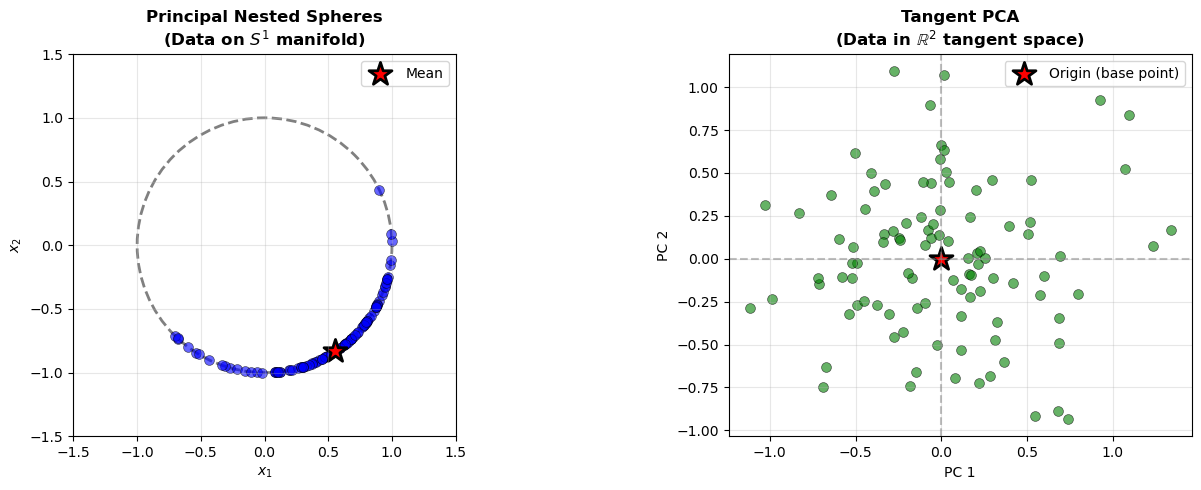


Key Differences:
- PNS: Output lives on S^1 manifold, preserves spherical structure
- TPCA: Output lives in R^2 tangent space, linear structure
- PNS is better for data with intrinsic spherical distribution
- TPCA is better for data concentrated around a mean with small variance


In [12]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PNS on S^1
ax1 = axes[0]
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', linewidth=2)
ax1.add_patch(circle)
ax1.scatter(X_pns[:, 0], X_pns[:, 1], c='blue', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax1.scatter(pns_compare.mean_[0], pns_compare.mean_[1], c='red', s=300, marker='*', 
           label='Mean', edgecolors='black', linewidth=2)
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_aspect('equal')
ax1.set_title('Principal Nested Spheres\n(Data on $S^1$ manifold)', 
             fontsize=12, fontweight='bold')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Tangent PCA in R^2
ax2 = axes[1]
ax2.scatter(X_tpca[:, 0], X_tpca[:, 1], c='green', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax2.scatter(0, 0, c='red', s=300, marker='*', 
           label='Origin (base point)', edgecolors='black', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_aspect('equal')
ax2.set_title('Tangent PCA\n(Data in $\\mathbb{R}^2$ tangent space)', 
             fontsize=12, fontweight='bold')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Differences:")
print("- PNS: Output lives on S^1 manifold, preserves spherical structure")
print("- TPCA: Output lives in R^2 tangent space, linear structure")
print("- PNS is better for data with intrinsic spherical distribution")
print("- TPCA is better for data concentrated around a mean with small variance")

## 6. Application: Clustering in Reduced Space

PNS can be used as a preprocessing step for downstream tasks like clustering.

In [13]:
from geomstats.learning.kmeans import RiemannianKMeans

# Generate data with two clusters
sphere_cluster = Hypersphere(dim=2)
n_per_cluster = 40

# Cluster 1
mean1 = gs.array([1., 0., 0.])
cluster1 = sphere_cluster.random_von_mises_fisher(kappa=15, n_samples=n_per_cluster)

# Cluster 2 (opposite side)
mean2 = gs.array([-1., 0., 0.])
# Generate around mean2 by rotating cluster around mean2
cluster2_base = sphere_cluster.random_von_mises_fisher(kappa=15, n_samples=n_per_cluster)
# Reflect through origin to move to opposite side
cluster2 = -cluster2_base

X_clusters = gs.concatenate([cluster1, cluster2], axis=0)
true_labels = gs.array([0] * n_per_cluster + [1] * n_per_cluster)

# Apply PNS
pns_cluster = PrincipalNestedSpheres(space=sphere_cluster, n_init=10)
pns_cluster.fit(X_clusters)
X_clusters_reduced = pns_cluster.transform(X_clusters)

# Cluster in reduced space
circle_space = Hypersphere(dim=1)
kmeans = RiemannianKMeans(space=circle_space, n_clusters=2)
kmeans.fit(X_clusters_reduced)
predicted_labels = kmeans.labels_

print(f"Clustering completed!")
print(f"Cluster centers on S^1:")
print(kmeans.cluster_centers_)

Clustering completed!
Cluster centers on S^1:
[[ 0.99894533 -0.04591539]
 [-0.99987985  0.01550112]]


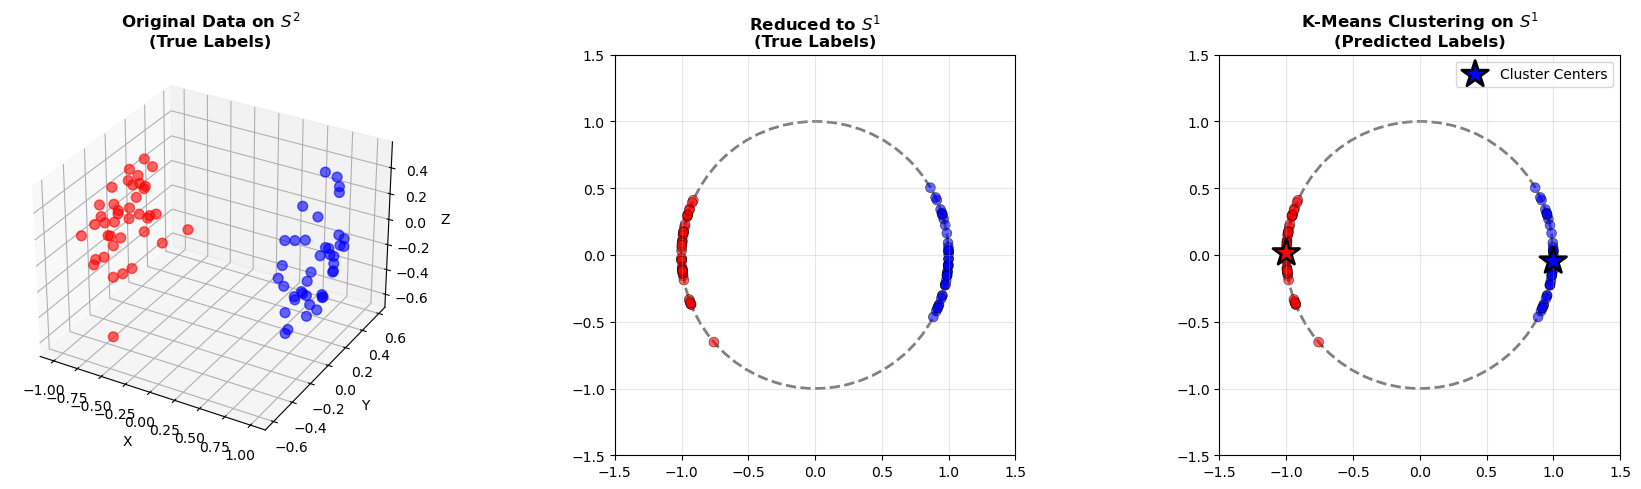


Adjusted Rand Index: 1.0000
(1.0 = perfect clustering, 0.0 = random)


In [14]:
# Visualize clustering results
fig = plt.figure(figsize=(18, 5))

# Original data with true labels
ax1 = fig.add_subplot(131, projection='3d')
colors_true = ['blue' if label == 0 else 'red' for label in true_labels]
ax1.scatter(X_clusters[:, 0], X_clusters[:, 1], X_clusters[:, 2], 
           c=colors_true, alpha=0.6, s=50)
ax1.set_title('Original Data on $S^2$\n(True Labels)', fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Reduced data with true labels
ax2 = fig.add_subplot(132)
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', linewidth=2)
ax2.add_patch(circle)
ax2.scatter(X_clusters_reduced[:, 0], X_clusters_reduced[:, 1], 
           c=colors_true, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.set_title('Reduced to $S^1$\n(True Labels)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Reduced data with predicted labels
ax3 = fig.add_subplot(133)
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', linewidth=2)
ax3.add_patch(circle)
colors_pred = ['blue' if label == 0 else 'red' for label in predicted_labels]
ax3.scatter(X_clusters_reduced[:, 0], X_clusters_reduced[:, 1], 
           c=colors_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
# Plot cluster centers
centers = kmeans.cluster_centers_
ax3.scatter(centers[:, 0], centers[:, 1], c=['blue', 'red'], 
           s=400, marker='*', edgecolors='black', linewidth=2, 
           label='Cluster Centers', zorder=10)
ax3.set_xlim(-1.5, 1.5)
ax3.set_ylim(-1.5, 1.5)
ax3.set_aspect('equal')
ax3.set_title('K-Means Clustering on $S^1$\n(Predicted Labels)', 
             fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute clustering accuracy (accounting for label permutation)
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"\nAdjusted Rand Index: {ari:.4f}")
print("(1.0 = perfect clustering, 0.0 = random)")

## Summary

This notebook demonstrated:

1. **Basic PNS usage**: Reducing data from $S^n$ to $S^1$
2. **Different fitting modes**: Adaptive, great sphere, and small sphere
3. **Higher-dimensional reduction**: Progressive reduction through nested subspheres
4. **Comparison with Tangent PCA**: Understanding when to use each method
5. **Practical application**: Using PNS as preprocessing for clustering

### When to use PNS:
- Data naturally lives on spheres
- Want to preserve manifold structure
- Data is spread across significant portion of sphere
- Need interpretable nested subsphere decomposition

### Key Parameters:
- `n_init`: Number of random initializations (higher = more robust, slower)
- `sphere_mode`: 'adaptive' (default), 'great', or 'small'
- `max_iter`: Maximum optimization iterations per fit
- `tol`: Convergence tolerance
- `verbose`: Print fitting information

### References:
- Jung, S., Dryden, I. L., & Marron, J. S. (2012). Analysis of principal nested spheres. *Biometrika*, 99(3), 551-568.
- Geomstats documentation: https://geomstats.github.io/